# Assignment 4: Word Embeddings

Welcome to the fourth (and last) programming assignment of Course 2!

In this assignment, you will practice how to compute word embeddings and use them for sentiment analysis.
- To implement sentiment analysis, you can go beyond counting the number of positive words and negative words.
- You can find a way to represent each word numerically, by a vector.
- The vector could then represent syntactic (i.e. parts of speech) and semantic (i.e. meaning) structures.

In this assignment, you will explore a classic way of generating word embeddings or representations.
- You will implement a famous model called the continuous bag of words (CBOW) model.

By completing this assignment you will:

- Train word vectors from scratch.
- Learn how to create batches of data.
- Understand how backpropagation works.
- Plot and visualize your learned word vectors.

Knowing how to train these models will give you a better understanding of word vectors, which are building blocks to many applications in natural language processing.

Before starting make sure that you are following the following assignment instructions

## Assignment Instructions
Create a Copy in Your Google Drive:
* Before you begin working on this assignment, you must create a copy of this Colab file in your own Google Drive.
* To do this, go to the menu bar at the top of this page, click on File > Save a copy in Drive.... This will save a copy of this file in your Google Drive under the name Copy of <Original File Name>. Rename the file.
* Ensure you are logged into your msitprogram.net account when doing this.

Work on Your Copy:
* Do not edit this original file.
* All your work must be done on the copy saved in your Google Drive. Any work done on this original file will not be saved and may be lost.

Saving Your Work:
* Google Colab automatically saves your progress in the copy stored in your Drive. However, it's a good practice to manually save your work periodically by clicking on File > Save.


Let's get started!!!

## Table of Contents

- [1 - The Continuous Bag of Words Model](#1)
- [2 - Training the Model](#2)
    - [2.1 - Initializing the Model](#2.1)
        - [Exercise 1 - initialize_model](#ex-1)
    - [2.2 - Softmax](#2.2)
        - [Exercise 2 - softmax](#ex-2)
    - [2.3 - Forward Propagation](#2.3)
        - [Exercise 3 - forward_prop](#ex-3)
    - [2.4 - Cost Function](#2.4)
    - [2.5 - Training the Model - Backpropagation](#2.5)
        - [Exercise 4 - back_prop](#ex-4)
    - [2.6 - Gradient Descent](#2.6)
        - [Exercise 5 - gradient_descent](#ex-5)
- [3 - Visualizing the Word Vectors](#3)


<a name='1'></a>
## 1 - The Continuous Bag of Words Model

Let's take a look at the following sentence:
>**'I am happy because I am learning'**.

- In continuous bag of words (CBOW) modeling, we try to predict the center word given a few context words (the words around the center word).
- For example, if you were to choose a context half-size of say $C = 2$, then you would try to predict the word **happy** given the context that includes 2 words before and 2 words after the center word:

> $C$ words before: [I, am]

> $C$ words after: [because, I]

- In other words:

$$context = [I,am, because, I]$$
$$target = happy$$

The structure of your model will look like this:

<div style="width:image width px; font-size:100%; text-align:center;"><img src='https://drive.google.com/uc?export=view&id=1Ln_VPg4KUuU76nGcY-m1JgYtAapbgXx0' alt="alternate text" width="width" height="height" style="width:600px;height:250px;" /> Figure 1 </div>

Where $\bar x$ is the average of all the one hot vectors of the context words.

<div style="width:image width px; font-size:100%; text-align:center;"><img src='https://drive.google.com/uc?=export=view&id=1g9VUIl20n46TstccfjT_pvPKMuTh2DFt' alt="alternate text" width="width" height="height" style="width:600px;height:250px;" /> Figure 2 </div>

Once you have encoded all the context words, you can use $\bar x$ as the input to your model.

The architecture you will be implementing is as follows:

\begin{align}
 h &= W_1 \  X + b_1  \tag{1} \\
 a &= ReLU(h)  \tag{2} \\
 z &= W_2 \  a + b_2   \tag{3} \\
 \hat y &= softmax(z)   \tag{4} \\
\end{align}

In [ ]:
# Import Python libraries
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
from collections import Counter, defaultdict
from scipy import linalg

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
def sigmoid(z):
    # sigmoid function
    return 1.0 / (1.0 + np.exp(-z))

In [ ]:
def get_idx(words, word2Ind):
    idx = []
    for word in words:
        idx = idx + [word2Ind[word]]
    return idx

In [ ]:
def pack_idx_with_frequency(context_words, word2Ind):
    freq_dict = defaultdict(int)
    for word in context_words:
        freq_dict[word] += 1
    idxs = get_idx(context_words, word2Ind)
    packed = []
    for i in range(len(idxs)):
        idx = idxs[i]
        freq = freq_dict[context_words[i]]
        packed.append((idx, freq))
    return packed

In [ ]:
def get_vectors(data, word2Ind, V, C):
    i = C
    while True:
        y = np.zeros(V)
        x = np.zeros(V)
        center_word = data[i]
        y[word2Ind[center_word]] = 1
        context_words = data[(i - C):i] + data[(i+1):(i+C+1)]
        num_ctx_words = len(context_words)
        for idx, freq in pack_idx_with_frequency(context_words, word2Ind):
            x[idx] = freq/num_ctx_words
        yield x, y
        i += 1
        if i >= len(data):
            print('i is being set to 0')
            i = 0

In [ ]:
def get_batches(data, word2Ind, V, C, batch_size):
    batch_x = []
    batch_y = []
    for x, y in get_vectors(data, word2Ind, V, C):
        if len(batch_x) < batch_size:
            batch_x.append(x)
            batch_y.append(y)
        else:
            yield np.array(batch_x).T, np.array(batch_y).T
            batch_x = []
            batch_y = []

In [ ]:
def compute_pca(data, n_components=2):
    """
    Input:
        data: of dimension (m,n) where each row corresponds to a word vector
        n_components: Number of components you want to keep.
    Output:
        X_reduced: data transformed in 2 dims/columns + regenerated original data
    pass in: data as 2D NumPy array
    """

    m, n = data.shape

    ### START CODE HERE ###
    # mean center the data
    data -= data.mean(axis=0)
    # calculate the covariance matrix
    R = np.cov(data, rowvar=False)
    # calculate eigenvectors & eigenvalues of the covariance matrix
    # use 'eigh' rather than 'eig' since R is symmetric,
    # the performance gain is substantial
    evals, evecs = linalg.eigh(R)
    # sort eigenvalue in decreasing order
    # this returns the corresponding indices of evals and evecs
    idx = np.argsort(evals)[::-1]

    evecs = evecs[:, idx]
    # sort eigenvectors according to same index
    evals = evals[idx]
    # select the first n eigenvectors (n is desired dimension
    # of rescaled data array, or dims_rescaled_data)
    evecs = evecs[:, :n_components]
    ### END CODE HERE ###
    return np.dot(evecs.T, data.T).T

In [ ]:
def get_dict(data):
    """
    Input:
        K: the number of negative samples
        data: the data you want to pull from
        indices: a list of word indices
    Output:
        word_dict: a dictionary with the weighted probabilities of each word
        word2Ind: returns dictionary mapping the word to its index
        Ind2Word: returns dictionary mapping the index to its word
    """
    #
    #     words = nltk.word_tokenize(data)
    words = sorted(list(set(data)))
    n = len(words)
    idx = 0
    # return these correctly
    word2Ind = {}
    Ind2word = {}
    for k in words:
        word2Ind[k] = idx
        Ind2word[idx] = k
        idx += 1
    return word2Ind, Ind2word

In [ ]:
# Download sentence tokenizer
nltk.data.path.append('.')

The data used in this assignment can be found [here](https://drive.google.com/file/d/1iBnaGuSCgYMmkjKFVWkw0p4RWJF5_CKL/view?usp=share_link)

Download the zip file to your local system, unzip it and upload the **shakespeare.txt** file to Google Colab by following the instructions below

### Connect to Your Local Runtime
If you haven’t connected to a local runtime yet, follow these steps:
1. Click on Connect in the top-right corner of the Google Colab interface.
2. Choose Connect to local runtime....
3. Follow the instructions to set up the local runtime.

### Open the Files Menu
1. On the left-hand side of your Google Colab notebook, you’ll see a vertical toolbar. Click on the folder icon to open the "Files" menu.
2. If the "Files" menu is not visible, you can open it by clicking on the three vertical dots in the toolbar and selecting Files.

### Upload Files
1. In the "Files" menu, click on the Upload button at the top (shaped like a file icon with an upward arrow).
2. A file selection dialog will appear. Browse your local file system and select the files you want to upload.
3. Once selected, the files will start uploading. You will see progress indicators next to each file as they upload.
4. After the upload is complete, the files will appear in the "Files" menu and will be available in your current working directory.

### Get the File Path
1. In the "Files" menu, right-click on the uploaded file.
2. Select Copy path from the context menu that appears.
3. The file path will be copied to your clipboard, and you can paste it directly into your code.

### Access Uploaded Files in Your Code
Now that you have the file path, you can access the file in your notebook. For example:

```python
import pandas as pd

# Use the copied file path to load the uploaded CSV file
df = pd.read_csv('/content/your_uploaded_file.csv')
print(df.head())
```
### Managing Files
You can also manage your files directly in the "Files" menu:
1. Create new folders: Right-click (or use the options menu) in the "Files" menu to create a new folder.
2. Delete files: Right-click on a file and select "Delete" to remove it from the environment.
3. Refresh: If you make changes to your files externally, you can click the refresh button in the "Files" menu to update the view.

### Additional Note:
Important: If the runtime resets (either due to a timeout, disconnection, or manual restart), all files uploaded through the "Files" menu will be lost, and you will need to upload them again.
Load the data and view the first few sentences by running the next cell.

In [ ]:
# Load, tokenize and process the data
import re                                                           #  Load the Regex-module
with open('/content/shakespeare.txt') as f:
    data = f.read()                                                 #  Read in the data
data = re.sub(r'[,!?;-]', '.',data)                                 #  Punktuations are replaced by .
data = nltk.word_tokenize(data)                                     #  Tokenize string to words
data = [ ch.lower() for ch in data if ch.isalpha() or ch == '.']    #  Lower case and drop non-alphabetical tokens
print("Number of tokens:", len(data),'\n', data[:15])               #  print data sample

Number of tokens: 60976 
 ['o', 'for', 'a', 'muse', 'of', 'fire', '.', 'that', 'would', 'ascend', 'the', 'brightest', 'heaven', 'of', 'invention']


In [ ]:
# Compute the frequency distribution of the words in the dataset (vocabulary)
fdist = nltk.FreqDist(word for word in data)
print("Size of vocabulary: ",len(fdist) )
print("Most frequent tokens: ",fdist.most_common(20) ) # print the 20 most frequent words and their freq.

Size of vocabulary:  5775
Most frequent tokens:  [('.', 9630), ('the', 1521), ('and', 1394), ('i', 1257), ('to', 1159), ('of', 1093), ('my', 857), ('that', 781), ('in', 770), ('a', 752), ('you', 748), ('is', 630), ('not', 559), ('for', 467), ('it', 460), ('with', 441), ('his', 434), ('but', 417), ('me', 417), ('your', 397)]


#### Mapping words to indices and indices to words
We provide a helper function to create a dictionary that maps words to indices and indices to words.

In [ ]:
# get_dict creates two dictionaries, converting words to indices and viceversa.
word2Ind, Ind2word = get_dict(data)
V = len(word2Ind)
print("Size of vocabulary: ", V)

Size of vocabulary:  5775


In [ ]:
# example of word to index mapping
print("Index of the word 'king' :  ",word2Ind['king'] )
print("Word which has index 2743:  ",Ind2word[2743] )

Index of the word 'king' :   2744
Word which has index 2743:   kinds


<a name='2'></a>
## 2 - Training the Model

<a name='2.1'></a>
### 2.1 - Initializing the Model

You will now initialize two matrices and two vectors.
- The first matrix ($W_1$) is of dimension $N \times V$, where $V$ is the number of words in your vocabulary and $N$ is the dimension of your word vector.
- The second matrix ($W_2$) is of dimension $V \times N$.
- Vector $b_1$ has dimensions $N\times 1$
- Vector $b_2$ has dimensions  $V\times 1$.
- $b_1$ and $b_2$ are the bias vectors of the linear layers from matrices $W_1$ and $W_2$.

The overall structure of the model will look as in Figure 1, but at this stage we are just initializing the parameters.

<a name='ex-1'></a>
### Exercise 1 - initialize_model
Please use [numpy.random.rand](https://numpy.org/doc/stable/reference/random/generated/numpy.random.rand.html) to generate matrices that are initialized with random values from a uniform distribution, ranging between 0 and 1.

**Note:** In the next cell you will encounter a random seed. Please **DO NOT** modify this seed so your solution can be tested correctly.

In [ ]:
def initialize_model(N,V, random_seed=1):
    """
    Inputs:
        N:  dimension of hidden vector
        V:  dimension of vocabulary
        random_seed: random seed for consistent results in the unit tests

     Outputs:
        W1, W2, b1, b2: initialized weights and biases
    """

    ### START CODE HERE (Replace instances of 'None' with your code) ###
    np.random.seed(random_seed)
    # W1 has shape (N,V)
    W1 = np.random.rand(N,V)

    # W2 has shape (V,N)
    W2 = np.random.rand(V,N)

    # b1 has shape (N,1)
    b1 = np.random.rand(N,1)

    # b2 has shape (V,1)
    b2 = np.random.rand(V,1)

    ### END CODE HERE ###
    return W1, W2, b1, b2

In [ ]:
# Test your function example.
tmp_N = 4
tmp_V = 10
tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(tmp_N,tmp_V)
assert tmp_W1.shape == ((tmp_N,tmp_V))
assert tmp_W2.shape == ((tmp_V,tmp_N))
print(f"tmp_W1.shape: {tmp_W1.shape}")
print(f"tmp_W2.shape: {tmp_W2.shape}")
print(f"tmp_b1.shape: {tmp_b1.shape}")
print(f"tmp_b2.shape: {tmp_b2.shape}")

tmp_W1.shape: (4, 10)
tmp_W2.shape: (10, 4)
tmp_b1.shape: (4, 1)
tmp_b2.shape: (10, 1)


##### Expected Output

```CPP
tmp_W1.shape: (4, 10)
tmp_W2.shape: (10, 4)
tmp_b1.shape: (4, 1)
tmp_b2.shape: (10, 1)
```

<a name='2.2'></a>
### 2.2 - Softmax
Before we can start training the model, we need to implement the softmax function as defined in equation 5:  

<br>
$$ \text{softmax}(z_i) = \frac{e^{z_i} }{\sum_{i=0}^{V-1} e^{z_i} }  \tag{5} $$

- Array indexing in code starts at 0.
- $V$ is the number of words in the vocabulary (which is also the number of rows of $z$).
- $i$ goes from 0 to |V| - 1.


<a name='ex-2'></a>
### Exercise 2 - softmax
**Instructions**: Implement the softmax function below.

- Assume that the input $z$ to `softmax` is a 2D array
- Each training example is represented by a vector of shape (V, 1) in this 2D array.
- There may be more than one column, in the 2D array, because you can put in a batch of examples to increase efficiency.  Let's call the batch size lowercase $m$, so the $z$ array has shape (V, m)
- When taking the sum from $i=1 \cdots V-1$, take the sum for each column (each example) separately.

Please use
- numpy.exp
- numpy.sum (set the axis so that you take the sum of each column in z)

In [ ]:
def softmax(z):
    """
    Inputs:
        z: output scores from the hidden layer

    Outputs:
        yhat: prediction (estimate of y)
    """
    ### START CODE HERE (Replace instances of 'None' with your own code) ###
    # Calculate yhat (softmax)
    yhat = np.exp(z) / np.sum(np.exp(z), axis=0)
    ### END CODE HERE ###
    return yhat

In [ ]:
# Test the function
tmp = np.array([[1,2,3],
                [1,1,1]
               ])
tmp_sm = softmax(tmp)
display(tmp_sm)

array([[0.5       , 0.73105858, 0.88079708],
       [0.5       , 0.26894142, 0.11920292]])

##### Expected Ouput

```CPP
array([[0.5       , 0.73105858, 0.88079708],
       [0.5       , 0.26894142, 0.11920292]])
```

<a name='2.3'></a>
### 2.3 - Forward Propagation

<a name='ex-3'></a>
### Exercise 3 - forward_prop
Implement the forward propagation $z$ according to equations (1) to (3). <br>

\begin{align}
 h &= W_1 \  X + b_1  \tag{1} \\
 h &= ReLU(h)  \tag{2} \\
 z &= W_2 \  h + b_2   \tag{3} \\
\end{align}

For that, you will use as activation the Rectified Linear Unit (ReLU) given by:

$$f(h)=\max (0,h) \tag{6}$$

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>You can use numpy.maximum(x1,x2) to get the maximum of two values</li>
    <li>Use numpy.dot(A,B) to matrix multiply A and B</li>
</ul>
</p>


In [ ]:
def forward_prop(x, W1, W2, b1, b2):
    """
    Inputs:
        x:  average one hot vector for the context
        W1, W2, b1, b2:  matrices and biases to be learned

    Outputs:
        z:  output score vector
    """

    ### START CODE HERE (Replace instances of 'None' with your own code) ###
    # Calculate h
    h = np.dot(W1, x) + b1

    # Apply the relu on h,
    # store the relu in h
    h = np.maximum(0, h)

    # Calculate z
    z = np.dot(W2, h) + b2

    ### END CODE HERE ###

    return z, h

In [ ]:
# Test the function

# Create some inputs
tmp_N = 2
tmp_V = 3
tmp_x = np.array([[0,1,0]]).T
#print(tmp_x)
tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(N=tmp_N,V=tmp_V, random_seed=1)

print(f"x has shape {tmp_x.shape}")
print(f"N is {tmp_N} and vocabulary size V is {tmp_V}")

# call function
tmp_z, tmp_h = forward_prop(tmp_x, tmp_W1, tmp_W2, tmp_b1, tmp_b2)
print("call forward_prop")
print()
# Look at output
print(f"z has shape {tmp_z.shape}")
print("z has values:")
print(tmp_z)

print()

print(f"h has shape {tmp_h.shape}")
print("h has values:")
print(tmp_h)

x has shape (3, 1)
N is 2 and vocabulary size V is 3
call forward_prop

z has shape (3, 1)
z has values:
[[0.55379268]
 [1.58960774]
 [1.50722933]]

h has shape (2, 1)
h has values:
[[0.92477674]
 [1.02487333]]


##### Expected output
```CPP
x has shape (3, 1)
N is 2 and vocabulary size V is 3
call forward_prop

z has shape (3, 1)
z has values:
[[0.55379268]
 [1.58960774]
 [1.50722933]]

h has shape (2, 1)
h has values:
[[0.92477674]
 [1.02487333]]
```

<a name='2.4'></a>
### 2.4 - Cost Function

- We have implemented the *cross-entropy* cost function for you.

In [ ]:
# compute_cost: cross-entropy cost function
def compute_cost(y, yhat, batch_size):

    # cost function
    logprobs = np.multiply(np.log(yhat),y)
    cost = - 1/batch_size * np.sum(logprobs)
    cost = np.squeeze(cost)
    return cost

In [ ]:
# Test the function
tmp_C = 2
tmp_N = 50
tmp_batch_size = 4
tmp_word2Ind, tmp_Ind2word = get_dict(data)
tmp_V = len(word2Ind)

tmp_x, tmp_y = next(get_batches(data, tmp_word2Ind, tmp_V,tmp_C, tmp_batch_size))

print(f"tmp_x.shape {tmp_x.shape}")
print(f"tmp_y.shape {tmp_y.shape}")

tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(tmp_N,tmp_V)

print(f"tmp_W1.shape {tmp_W1.shape}")
print(f"tmp_W2.shape {tmp_W2.shape}")
print(f"tmp_b1.shape {tmp_b1.shape}")
print(f"tmp_b2.shape {tmp_b2.shape}")

tmp_z, tmp_h = forward_prop(tmp_x, tmp_W1, tmp_W2, tmp_b1, tmp_b2)
print(f"tmp_z.shape: {tmp_z.shape}")
print(f"tmp_h.shape: {tmp_h.shape}")

tmp_yhat = softmax(tmp_z)
print(f"tmp_yhat.shape: {tmp_yhat.shape}")

tmp_cost = compute_cost(tmp_y, tmp_yhat, tmp_batch_size)
print("call compute_cost")
print(f"tmp_cost {tmp_cost:.4f}")

tmp_x.shape (5775, 4)
tmp_y.shape (5775, 4)
tmp_W1.shape (50, 5775)
tmp_W2.shape (5775, 50)
tmp_b1.shape (50, 1)
tmp_b2.shape (5775, 1)
tmp_z.shape: (5775, 4)
tmp_h.shape: (50, 4)
tmp_yhat.shape: (5775, 4)
call compute_cost
tmp_cost 10.3511


##### Expected output

```CPP
tmp_x.shape (5778, 4)
tmp_y.shape (5778, 4)
tmp_W1.shape (50, 5778)
tmp_W2.shape (5778, 50)
tmp_b1.shape (50, 1)
tmp_b2.shape (5778, 1)
tmp_z.shape: (5778, 4)
tmp_h.shape: (50, 4)
tmp_yhat.shape: (5778, 4)
call compute_cost
tmp_cost 10.5788
```

<a name='2.5'></a>
### 2.5 - Training the Model - Backpropagation

<a name='ex-4'></a>
### Exercise 4 - back_prop
Now that you have understood how the CBOW model works, you will train it. <br>
You created a function for the forward propagation. Now you will implement a function that computes the gradients to backpropagate the errors.

**Note**: `z1` is calculated as `W1⋅x + b1` in this function. In practice, you would save it already when making forward propagation and just re-use here, but for simplicity, it is calculated again in `back_prop`.

As reference, below are the equations of backpropagation as taught in the lecture:
<div style="width:image width px; font-size:100%; text-align:center;"><img src='https://drive.google.com/uc?export=view&id=1G82aKEuhE6yJnbYfwdkc8GJIIn00szg4' alt="alternate text" width="width" height="height" style="width:600px;height:250px;" /> </div>

In [ ]:
def back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size):
    """
    Inputs:
        x:  average one hot vector for the context
        yhat: prediction (estimate of y)
        y:  target vector
        h:  hidden vector (see eq. 1)
        W1, W2, b1, b2:  matrices and biases
        batch_size: batch size

     Outputs:
        grad_W1, grad_W2, grad_b1, grad_b2:  gradients of matrices and biases
    """

    # Compute z1 as "W1⋅x + b1"
    z1 = np.dot(W1, x) + b1

    ### START CODE HERE (Replace instances of 'None' with your code) ###

    # Compute l1 as W2^T (Yhat - Y)
    l1 = np.dot(W2.T, yhat - y)

    # if z1 < 0, then l1 = 0
    # otherwise l1 = l1
    # (this is already implemented for you)

    l1[z1 < 0] = 0 # use "l1" to compute gradients below

    # compute the gradient for W1
    grad_W1 = (1 / batch_size) * np.dot(l1, x.T)

    # Compute gradient of W2
    grad_W2 = (1 / batch_size) * np.dot(yhat - y, h.T)

    # compute gradient for b1
    grad_b1 = (1 / batch_size) * np.sum(l1, axis=1, keepdims=True)

    # compute gradient for b2
    grad_b2 = (1 / batch_size) * np.sum(yhat - y, axis=1, keepdims=True)
    ### END CODE HERE ####

    return grad_W1, grad_W2, grad_b1, grad_b2

In [ ]:
# Test the function
tmp_C = 2
tmp_N = 50
tmp_batch_size = 4
tmp_word2Ind, tmp_Ind2word = get_dict(data)
tmp_V = len(word2Ind)


# get a batch of data
tmp_x, tmp_y = next(get_batches(data, tmp_word2Ind, tmp_V,tmp_C, tmp_batch_size))

print("get a batch of data")
print(f"tmp_x.shape {tmp_x.shape}")
print(f"tmp_y.shape {tmp_y.shape}")

print()
print("Initialize weights and biases")
tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(tmp_N,tmp_V)

print(f"tmp_W1.shape {tmp_W1.shape}")
print(f"tmp_W2.shape {tmp_W2.shape}")
print(f"tmp_b1.shape {tmp_b1.shape}")
print(f"tmp_b2.shape {tmp_b2.shape}")

print()
print("Forwad prop to get z and h")
tmp_z, tmp_h = forward_prop(tmp_x, tmp_W1, tmp_W2, tmp_b1, tmp_b2)
print(f"tmp_z.shape: {tmp_z.shape}")
print(f"tmp_h.shape: {tmp_h.shape}")

print()
print("Get yhat by calling softmax")
tmp_yhat = softmax(tmp_z)
print(f"tmp_yhat.shape: {tmp_yhat.shape}")

tmp_m = (2*tmp_C)
tmp_grad_W1, tmp_grad_W2, tmp_grad_b1, tmp_grad_b2 = back_prop(tmp_x, tmp_yhat, tmp_y, tmp_h, tmp_W1, tmp_W2, tmp_b1, tmp_b2, tmp_batch_size)

print()
print("call back_prop")
print(f"tmp_grad_W1.shape {tmp_grad_W1.shape}")
print(f"tmp_grad_W2.shape {tmp_grad_W2.shape}")
print(f"tmp_grad_b1.shape {tmp_grad_b1.shape}")
print(f"tmp_grad_b2.shape {tmp_grad_b2.shape}")

get a batch of data
tmp_x.shape (5775, 4)
tmp_y.shape (5775, 4)

Initialize weights and biases
tmp_W1.shape (50, 5775)
tmp_W2.shape (5775, 50)
tmp_b1.shape (50, 1)
tmp_b2.shape (5775, 1)

Forwad prop to get z and h
tmp_z.shape: (5775, 4)
tmp_h.shape: (50, 4)

Get yhat by calling softmax
tmp_yhat.shape: (5775, 4)

call back_prop
tmp_grad_W1.shape (50, 5775)
tmp_grad_W2.shape (5775, 50)
tmp_grad_b1.shape (50, 1)
tmp_grad_b2.shape (5775, 1)


##### Expected output

```CPP
get a batch of data
tmp_x.shape (5778, 4)
tmp_y.shape (5778, 4)

Initialize weights and biases
tmp_W1.shape (50, 5778)
tmp_W2.shape (5778, 50)
tmp_b1.shape (50, 1)
tmp_b2.shape (5778, 1)

Forwad prop to get z and h
tmp_z.shape: (5778, 4)
tmp_h.shape: (50, 4)

Get yhat by calling softmax
tmp_yhat.shape: (5778, 4)

call back_prop
tmp_grad_W1.shape (50, 5778)
tmp_grad_W2.shape (5778, 50)
tmp_grad_b1.shape (50, 1)
tmp_grad_b2.shape (5778, 1)
```

<a name='2.6'></a>
### 2.6 - Gradient Descent

<a name='ex-5'></a>
### Exercise 5 - gradient_descent
Now that you have implemented a function to compute the gradients, you will implement batch gradient descent over your training set.

**Hint:** For that, you will use `initialize_model` and the `back_prop` functions which you just created (and the `compute_cost` function). You can also use the provided `get_batches` helper function:

```for x, y in get_batches(data, word2Ind, V, C, batch_size):```

```...```

Also: print the cost after each batch is processed (use batch size = 128)

In [ ]:
def gradient_descent(data, word2Ind, N, V, num_iters, alpha=0.03,
                     random_seed=282, initialize_model=initialize_model,
                     get_batches=get_batches, forward_prop=forward_prop,
                     softmax=softmax, compute_cost=compute_cost,
                     back_prop=back_prop):
    """
    This is the gradient_descent function

      Inputs:
        data:      text
        word2Ind:  words to Indices
        N:         dimension of hidden vector
        V:         dimension of vocabulary
        num_iters: number of iterations
        random_seed: random seed to initialize the model's matrices and vectors
        initialize_model: your implementation of the function to initialize the model
        get_batches: function to get the data in batches
        forward_prop: your implementation of the function to perform forward propagation
        softmax: your implementation of the softmax function
        compute_cost: cost function (Cross entropy)
        back_prop: your implementation of the function to perform backward propagation
     Outputs:
        W1, W2, b1, b2:  updated matrices and biases after num_iters iterations

    """
    W1, W2, b1, b2 = initialize_model(N,V, random_seed=random_seed) #W1=(N,V) and W2=(V,N)

    batch_size = 128
    iters = 0
    C = 2

    for x, y in get_batches(data, word2Ind, V, C, batch_size):
        ### START CODE HERE (Replace instances of 'None' with your own code) ###
        # get z and h
        z, h = forward_prop(x, W1, W2, b1, b2)

        # get yhat
        yhat = softmax(z)

        # get cost
        cost = compute_cost(y, yhat, batch_size)
        if ( (iters+1) % 10 == 0):
            print(f"iters: {iters + 1} cost: {cost:.6f}")

        # get gradients
        grad_W1, grad_W2, grad_b1, grad_b2 = back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size)

        # update weights and biases
        W1 = W1 - alpha * grad_W1
        W2 = W2 - alpha * grad_W2
        b1 = b1 - alpha * grad_b1
        b2 = b2 - alpha * grad_b2

        ### END CODE HERE ###
        iters +=1
        if iters == num_iters:
            break
        if iters % 100 == 0:
            alpha *= 0.66

    return W1, W2, b1, b2

In [ ]:
# test your function

C = 2
N = 50
word2Ind, Ind2word = get_dict(data)
V = len(word2Ind)
num_iters = 150
print("Call gradient_descent")
W1, W2, b1, b2 = gradient_descent(data, word2Ind, N, V, num_iters)

Call gradient_descent
iters: 10 cost: 9.513211
iters: 20 cost: 9.476105
iters: 30 cost: 9.543887
iters: 40 cost: 9.370119
iters: 50 cost: 8.752134
iters: 60 cost: 8.645475
iters: 70 cost: 8.777353
iters: 80 cost: 8.683993
iters: 90 cost: 8.785594
iters: 100 cost: 8.286367
iters: 110 cost: 8.527792
iters: 120 cost: 8.414913
iters: 130 cost: 8.099485
iters: 140 cost: 8.282044
iters: 150 cost: 8.239267


##### Expected Output

```python
iters: 10 cost: 9.686791
iters: 20 cost: 10.297529
iters: 30 cost: 10.051127
iters: 40 cost: 9.685962
iters: 50 cost: 9.369307
iters: 60 cost: 9.400293
iters: 70 cost: 9.060542
iters: 80 cost: 9.054266
iters: 90 cost: 8.765818
iters: 100 cost: 8.516531
iters: 110 cost: 8.708745
iters: 120 cost: 8.660616
iters: 130 cost: 8.544338
iters: 140 cost: 8.454268
iters: 150 cost: 8.475693
```        
        
Your numbers may differ a bit depending on which version of Python you're using.

<a name='3'></a>
## 3 - Visualizing the Word Vectors

In this part you will visualize the word vectors trained using the function you just coded above.

In [ ]:
# visualizing the word vectors here
from matplotlib import pyplot
%config InlineBackend.figure_format = 'svg'
words = ['king', 'queen','lord','man', 'woman','dog','wolf',
         'rich','happy','sad']

embs = (W1.T + W2)/2.0

# given a list of words and the embeddings, it returns a matrix with all the embeddings
idx = [word2Ind[word] for word in words]
X = embs[idx, :]
print(X.shape, idx)  # X.shape:  Number of words of dimension N each

(10, 50) [2744, 3949, 2960, 3022, 5672, 1452, 5671, 4189, 2315, 4276]


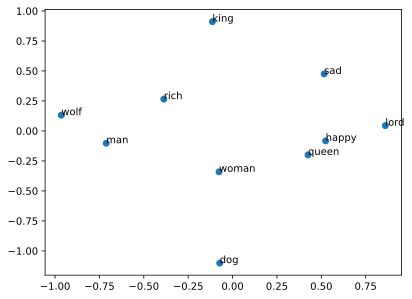

In [ ]:
result= compute_pca(X, 2)
pyplot.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

You can see that man and king are next to each other. However, we have to be careful with the interpretation of this projected word vectors, since the PCA depends on the projection -- as shown in the following illustration.

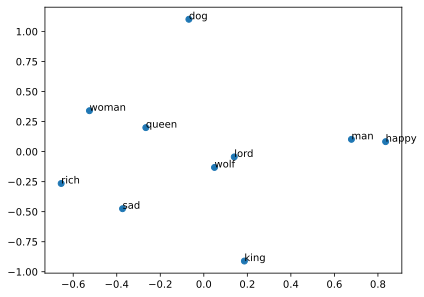

In [ ]:
result= compute_pca(X, 4)
pyplot.scatter(result[:, 3], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 3], result[i, 1]))
pyplot.show()